In [ ]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
import matplotlib.pyplot as plt 
from bliss.encoders.autoencoder import OneCenteredGalaxyAE
import torch
import numpy as np

import pytorch_lightning as L

from bliss.datasets.table_utils import column_to_tensor
from bliss.datasets.lsst import prepare_final_galaxy_catalog, prepare_final_star_catalog, get_default_lsst_psf
from astropy.table import Table

from bliss.datasets.generate_blends import generate_dataset


# Ovefit deblender training

In [ ]:
ae = OneCenteredGalaxyAE().eval()
ae.load_state_dict(torch.load("../../models/autoencoder_42.pt", weights_only=True))

<All keys matched successfully>

In [ ]:

from bliss.encoders.deblend import GalaxyEncoder


model = GalaxyEncoder("../../models/autoencoder_42.pt", lr=1e-3)

In [ ]:
_cat = Table.read("../../../data/OneDegSq.fits")
# _star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"),"i_ab")
CATSIM_CAT = _cat[_cat['i_ab'] < 23] # only bright for testing
STAR_MAGS = prepare_final_star_catalog()

PSF = get_default_lsst_psf()

In [ ]:
# get some blends
L.seed_everything(42)


# galaxy_density = 200
ds = generate_dataset(100, CATSIM_CAT, STAR_MAGS, PSF, 10, slen=40, galaxy_density=200, star_density=0, add_galaxies_in_padding=True)

Seed set to 42
100%|██████████| 100/100 [00:11<00:00,  9.03it/s]


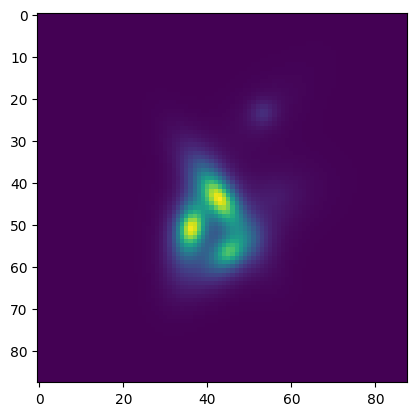

In [ ]:
idx = 21
plt.imshow(ds['noiseless'][idx,  0]  - ds['paddings'][idx, 0])

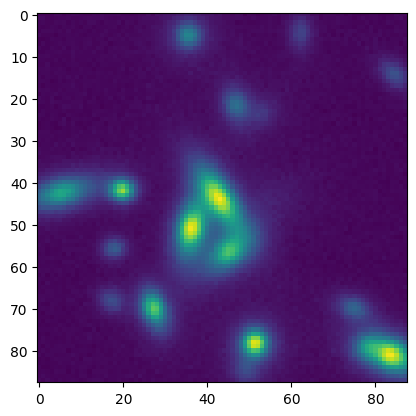

In [ ]:
plt.imshow(ds['images'][idx, 0])

In [ ]:

import torch
from torch import Tensor
from torch.utils.data import Dataset

from bliss.catalog import FullCatalog


class BlendBatches(Dataset):
    def __init__(
        self,
        ds: dict,
        slen: int = 40,
        tile_slen: int = 4,
        keep_padding: bool = False,
    ) -> None:
        super().__init__()

        self.images = ds.pop("images").float()  # needs to be a float for NN
        self.background = ds.pop("background").float()
        self.epoch_size = len(self.images)

        # don't need for training
        ds.pop("centered_sources")
        ds.pop("uncentered_sources")
        ds.pop("noiseless")

        # avoid large memory usage if we don't need padding.
        if not keep_padding:
            ds.pop("paddings")
            self.paddings = torch.tensor(0.).float()
        else:
            self.paddings = ds.pop("paddings").float()
        self.keep_padding = keep_padding

        full_catalog = FullCatalog(slen, slen, ds)
        tile_catalogs = full_catalog.to_tile_params(tile_slen, ignore_extra_sources=True)
        self.tile_params = tile_catalogs.to_dict()

    def __len__(self) -> int:
        return self.epoch_size

    def __getitem__(self, index) -> dict[str, Tensor]:
        tile_params_ii = {p: q[index] for p, q in self.tile_params.items()}
        return {
            "images": self.images[index],
            "background": self.background[index],
            "paddings": self.paddings[index] if self.keep_padding else self.paddings,
            **tile_params_ii,
        }

In [ ]:
# # overfit deblender to this once source


# trainer = L.Trainer(
#     limit_train_batches=1.0,
#     max_epochs=20,
#     accelerator="cpu",
#     devices=1,
#     check_val_every_n_epoch=1000000,
#     log_every_n_steps=10,
# )


In [ ]:
from torch.utils.data import DataLoader, Dataset

train_ds = BlendBatches({**ds}, keep_padding=True)
val_ds = BlendBatches({**ds}, keep_padding=True)

train_dl = DataLoader(train_ds, batch_size=100, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=100, num_workers=0)


In [ ]:

from torch.optim import Adam
from tqdm import tqdm

from bliss.datasets.generate_blends import parse_dataset

# gpu 
gpu = torch.device("cuda:0")
model = model.to(gpu)

opt = Adam(model.parameters(), lr=1e-3)
loss_iter = []


for ii in tqdm(range(2000), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    model.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat, paddings = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        paddings = paddings.to(gpu)
        loss = model.get_loss(images, paddings, background, truth_cat)
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        train_n_batches+=1 

    running_loss /= train_n_batches
    loss_iter.append(running_loss)


epoch:: 100%|██████████| 2000/2000 [01:55<00:00, 17.25it/s]


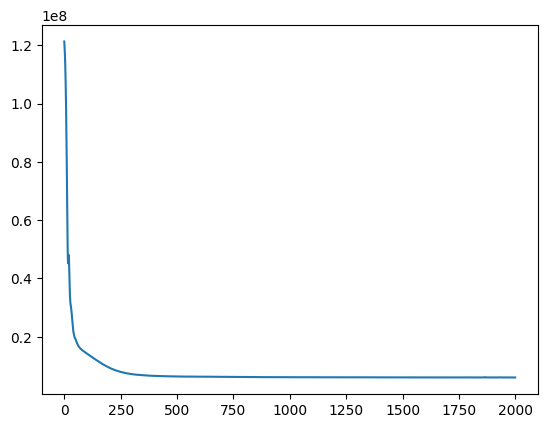

In [ ]:
plt.plot(loss_iter)

## Check correctness of images

In [ ]:
slen = 40
tile_slen = 4
exclude = {'images', 'background', 'paddings', 'centered_sources', 'uncentered_sources', 'noiseless'}
full_catalog = FullCatalog(slen, slen, {p:q for p, q in ds.items() if p not in exclude})
tile_catalog = full_catalog.to_tile_params(tile_slen, ignore_extra_sources=True)

In [ ]:
# now let's check deblender performance
cpu = torch.device("cpu")
model = model.eval().to("cpu")

images =ds['images'].float()
background = ds['background'].float()

with torch.no_grad():
    gparams = model.variational_mode(images, background, tile_catalog)
gparams.shape

torch.Size([100, 10, 10, 8])

In [ ]:
from bliss.render_tiles import render_galaxy_ptiles
from bliss.render_tiles import reconstruct_image_from_ptiles


ptiles = render_galaxy_ptiles(model._dec, tile_catalog.locs, gparams, tile_catalog['galaxy_bools'], 52, 4, )

recon = reconstruct_image_from_ptiles(ptiles, 4)
ptiles.shape, recon.shape

(torch.Size([100, 10, 10, 1, 52, 52]), torch.Size([100, 1, 88, 88]))

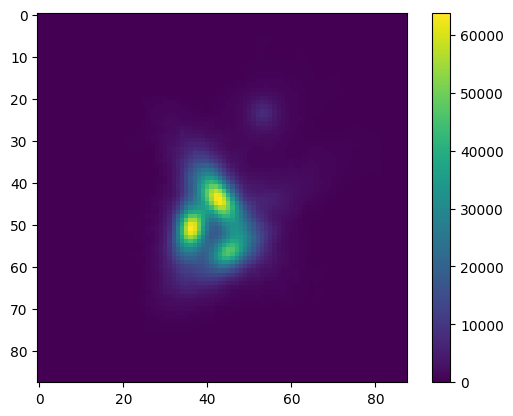

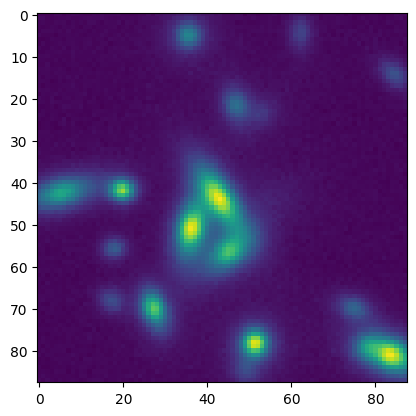

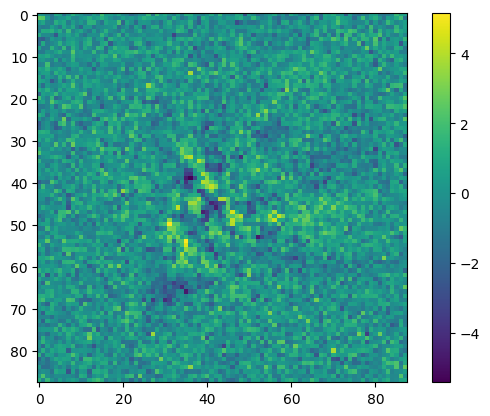

In [ ]:
idx = 21
ds['n_sources'][idx]

plt.imshow(recon[idx, 0])
plt.colorbar()
plt.show()
plt.imshow(images[idx, 0] )
plt.show()
x = recon[idx, 0] + ds['background'][idx, 0]
y = images[idx, 0] - ds['paddings'][idx, 0]
plt.imshow( (y - x) / x.sqrt())
plt.colorbar()

## Compare fluxes

In [ ]:
fluxes_true = ds['centered_sources'][idx][:, 0].sum(axis=(-1, -2)).log10()

fluxes_true

tensor([6.7126, 6.6050, 5.9401, 5.9465, 6.8028,   -inf,   -inf,   -inf,   -inf,
          -inf])

In [ ]:
# need to get full catalog from prediction on gparams

from bliss.catalog import TileCatalog
from copy import deepcopy
tile_catalog_pred = deepcopy(tile_catalog)
tile_catalog_pred['galaxy_params'] = gparams

tile_catalog_pred['galaxy_params'].shape
full_catalog_pred = tile_catalog_pred.to_full_params()
full_catalog_pred['galaxy_params'].shape
# tile_cat_pred = TileCatalog(4, {'n_sources': ds['n']})

torch.Size([100, 10, 8])

In [ ]:
# # recon fluxes
# from einops import rearrange
# b, nth, ntw, _ = gparams.shape
# galaxy_params_flat = rearrange(gparams, 'b nth ntw d -> (b nth ntw) d')
# singles = model._dec(galaxy_params_flat)
# recon_fluxes = singles.sum(axis=(1, 2, 3))
# recon_fluxes = rearrange(recon_fluxes, '(b nth ntw) -> b nth ntw', b=b, nth=nth, ntw=ntw)
# _recon_fluxes = recon_fluxes[idx].log10()
# _recon_fluxes

In [ ]:
gparams_idx = full_catalog_pred['galaxy_params'][idx]
singles = model._dec(gparams_idx)
recon_fluxes = singles.sum(axis=(1, 2, 3)).log10()
recon_fluxes

tensor([6.0141, 6.8016, 5.8982, 6.6978, 6.5986,   -inf,   -inf,   -inf,   -inf,
          -inf])

In [ ]:
recon_fluxes.sort()[0], fluxes_true.sort()[0] # they  match!!!!!

(tensor([  -inf,   -inf,   -inf,   -inf,   -inf, 5.8982, 6.0141, 6.5986, 6.6978,
         6.8016]),
 tensor([  -inf,   -inf,   -inf,   -inf,   -inf, 5.9401, 5.9465, 6.6050, 6.7126,
         6.8028]))

In [ ]:
# percentage difference
f1 = 10**recon_fluxes.sort()[0]
f2 = 10**fluxes_true.sort()[0]
(f1 - f2) / f2

tensor([    nan,     nan,     nan,     nan,     nan, -0.0920,  0.1685, -0.0146,
        -0.0333, -0.0029])

## How robust to incorrect locations???

In [ ]:
# we will slightly change the tile_catalog locations 

tile_catalog_new = deepcopy(tile_catalog)
tile_catalog_new.locs = torch.clip(tile_catalog_new.locs + torch.rand(size=(100, 10, 10, 2)) * 0.1, min=0, max=1)



cpu = torch.device("cpu")
model = model.eval().to("cpu")

images =ds['images'].float()
background = ds['background'].float()

with torch.no_grad():
    gparams = model.variational_mode(images, background, tile_catalog_new)
gparams.shape

torch.Size([100, 10, 10, 8])

In [ ]:
torch.rand((1,))* 0.05*4

tensor([0.1856])

In [ ]:
### BUT, use true locations for prediction to avoid dipoles, only one effect of decentring on galaxy param prediction

from bliss.render_tiles import render_galaxy_ptiles
from bliss.render_tiles import reconstruct_image_from_ptiles


ptiles = render_galaxy_ptiles(model._dec, tile_catalog.locs, gparams, tile_catalog['galaxy_bools'], 52, 4, )

recon = reconstruct_image_from_ptiles(ptiles, 4)
ptiles.shape, recon.shape

(torch.Size([100, 10, 10, 1, 52, 52]), torch.Size([100, 1, 88, 88]))

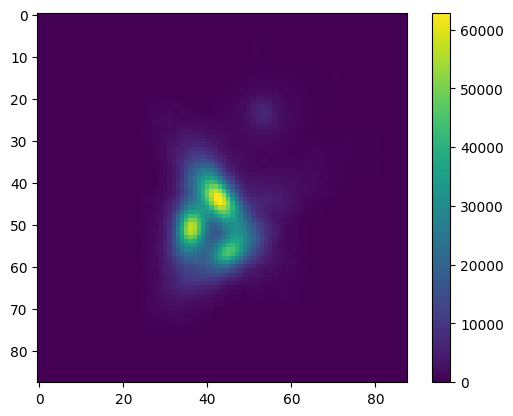

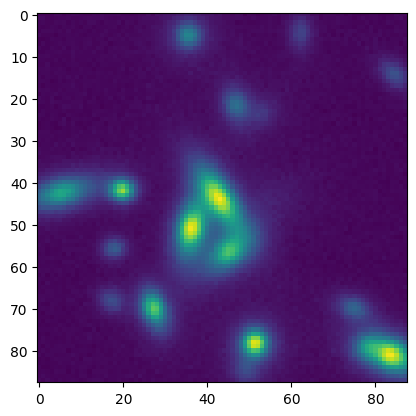

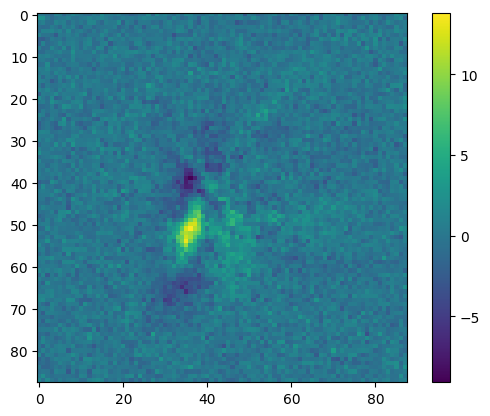

In [ ]:
idx = 21
ds['n_sources'][idx]

plt.imshow(recon[idx, 0])
plt.colorbar()
plt.show()
plt.imshow(images[idx, 0] )
plt.show()
x = recon[idx, 0] + ds['background'][idx, 0]
y = images[idx, 0] - ds['paddings'][idx, 0]
plt.imshow( (y - x) / x.sqrt())
plt.colorbar()

In [ ]:
fluxes_true = ds['centered_sources'][idx][:, 0].sum(axis=(-1, -2)).log10()

In [ ]:
# need to get full catalog from prediction on gparams

from bliss.catalog import TileCatalog
from copy import deepcopy
tile_catalog_pred2 = deepcopy(tile_catalog)
tile_catalog_pred2['galaxy_params'] = gparams

tile_catalog_pred2['galaxy_params'].shape
full_catalog_pred2 = tile_catalog_pred2.to_full_params()
full_catalog_pred2['galaxy_params'].shape

torch.Size([100, 10, 8])

In [ ]:
gparams_idx = full_catalog_pred2['galaxy_params'][idx]
singles = model._dec(gparams_idx)
recon_fluxes = singles.sum(axis=(1, 2, 3)).log10()

In [ ]:
recon_fluxes.sort()[0], fluxes_true.sort()[0]  #mostly  slight deviations

(tensor([  -inf,   -inf,   -inf,   -inf,   -inf, 5.9023, 6.0255, 6.5621, 6.7147,
         6.8019]),
 tensor([  -inf,   -inf,   -inf,   -inf,   -inf, 5.9401, 5.9465, 6.6050, 6.7126,
         6.8028]))

In [ ]:
# percentage difference
f1 = 10**recon_fluxes.sort()[0]
f2 = 10**fluxes_true.sort()[0]
(f1 - f2) / f2

tensor([    nan,     nan,     nan,     nan,     nan, -0.0834,  0.1995, -0.0941,
         0.0049, -0.0022])